## Finding the center of a circle
Christopher Fichtlscherer, 29.05.2020, fichtlscherer@mailbox.org

In [2]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
import matplotlib.pyplot as plt

### Create Circle Data

In [85]:
def create_circle_array(x_size, y_size, center_x, center_y, thickness, radius):
    """creates a binary, two dim numpy array in which a circle has the
        value 1 all other values are 0"""

    x_mesh, y_mesh = np.mgrid[:x_size, :y_size]

    circle = (x_mesh - center_x) ** 2 + (y_mesh - center_y) ** 2

    c_array = np.logical_and(circle < (radius**2 + thickness), circle > (radius**2 - thickness)).astype(float)

    return c_array

In [98]:
n = 500 # the number of arrays we want to create

split = 300 # till wich use the data for training
epos = 50

x_size, y_size = 100, 100 # size of the array
center_x, center_y = 50, 50 # center of the circle
delta_x, delta_y = 10, 10 # center will be random in [center_x - delta_x: center_x + delta_x]

thickness = 25 # thickness of the circle
radius = 20 # radius of the circle
delta_r = 5 # radius will be random in [radius - delta_r: radius + delta_r]

noise_level = 0.6

circles = np.zeros((n, x_size, y_size))
c_attributes = np.zeros((n, 3))

for i in tqdm(range(n)):
    
    cx = center_x + delta_x * (2 * (np.random.random()-0.5))
    cy = center_y + delta_y * (2 * (np.random.random()-0.5))
    r = radius + delta_r * (2 * (np.random.random()-0.5))

    attributes = np.array([cx, cy, r])
    c_array = create_circle_array(x_size, y_size, cx, cy, thickness, r)    

    circles[i] = c_array + noise_level * np.random.random((x_size, y_size))
    c_attributes[i] = attributes

100%|██████████| 500/500 [00:00<00:00, 1136.27it/s]


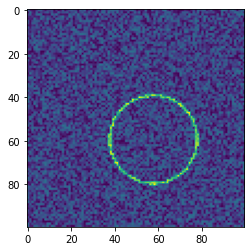

In [114]:
plt.imshow(circles[9])

In [100]:
print(circles.shape)
print(c_attributes.shape)

circles_ex = np.expand_dims(circles, axis=3)

print(circles_ex.shape)

train_circles, test_circles = circles_ex[:split], circles_ex[split:]
train_attributes, test_attributes = c_attributes[:split], c_attributes[split:]

print(train_circles.shape)
print(train_attributes.shape)

(500, 100, 100)
(500, 3)
(500, 100, 100, 1)
(300, 100, 100, 1)
(300, 3)


In [101]:
model = keras.Sequential([
    keras.layers.Conv2D(filters = 5, kernel_size = 22, input_shape=(x_size, y_size, 1)),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(filters = 5, kernel_size = 18),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(3)
])

In [102]:
model.compile(loss= "mean_squared_error" , optimizer="adam")

In [103]:
model.fit(train_circles, train_attributes, epochs=epos)

Epoch 1/50
300/300 [==============================] - 10s 34ms/sample - loss: 1071.4813
Epoch 2/50
300/300 [==============================] - 10s 33ms/sample - loss: 166.1429
Epoch 3/50
300/300 [==============================] - 10s 33ms/sample - loss: 67.7464
Epoch 4/50
300/300 [==============================] - 10s 33ms/sample - loss: 44.8850
Epoch 5/50
300/300 [==============================] - 10s 32ms/sample - loss: 31.2075
Epoch 6/50
300/300 [==============================] - 10s 34ms/sample - loss: 30.4752
Epoch 7/50
300/300 [==============================] - 10s 34ms/sample - loss: 28.1077
Epoch 8/50
300/300 [==============================] - 10s 33ms/sample - loss: 30.0840
Epoch 9/50
300/300 [==============================] - 10s 33ms/sample - loss: 27.0645
Epoch 10/50
300/300 [==============================] - 10s 34ms/sample - loss: 27.5807
Epoch 11/50
300/300 [==============================] - 10s 32ms/sample - loss: 26.4809
Epoch 12/50
300/300 [============================

In [104]:
predictions = model.predict(test_circles)

for i in range(30):
    print(max(abs(predictions[i]- test_attributes[i])))

1.69830661845225
2.722840664069288
2.234244986417057
2.4567851048192004
2.813624328041982
2.853063480664723
2.7253668839589835
3.193846726591346
1.5963107217220696
1.1871789600583078
2.334834439309688
2.150867268949682
1.6827128924534804
2.3367151731113083
2.9065458144341676
2.6472995480497374
4.218730891219707
1.1191068405310602
1.6922233838887522
1.679228259534355
3.040302638525837
3.0710621509981024
1.389283453690254
2.181818626109518
2.9203996854321623
1.924222980867178
2.3381216311037463
2.749893182348501
1.2117200085803361
2.3264993656424124


***

### Plot a box around the Circle

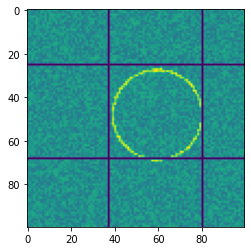

In [113]:
circle_number = 9

cx, cy, r = predictions[circle_number]

x_1 = int(cx - r)
x_2 = int(cx + r)

y_1 = int(cy - r)
y_2 = int(cy + r)

test_circle_2d = test_circles[circle_number,:,:,0]

w_image = test_circle_2d.copy()
w_image[:,y_1] = -1
w_image[:,y_2] = -1
w_image[x_1-1 : x_1] = -1
w_image[x_2-1 : x_2] = -1

plt.imshow(w_image)